### MPA_SVM

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

### Saving into Log

In [3]:

import logging

# Setup basic configuration for logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[
                        logging.FileHandler("SVM_optimization_PTB_XL.log"),  # Log to this file
                        logging.StreamHandler()  # Log to standard output
                    ])


### Determining necessary parameters

In [4]:
import numpy as np

# Example usage with the correct bounds for SVM:
search_agents_no = 15  # number of search agents
dim = 2  # number of dimensions / hyperparameters
Max_iter = 20  # Maximum number of iterations

# Lower and upper bounds for the 'gamma' and 'C' parameters of SVM
gamma_lb = -3
gamma_ub = 1
C_lb = -3
C_ub = 3

ub = np.array([C_ub, gamma_ub])  # upper bounds for each dimension
lb = np.array([C_lb, gamma_lb])  # lower bounds for each dimension



### Loading Training Dataset

In [3]:
import cudf
from cuml.svm import SVC as cumlSVC
from cuml.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from cuml.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Load and prepare data
train_data = cudf.read_csv('/home/jupyter-yangiev/MPA_int_ML/Train_new.csv')
print("Data loaded successfully:")
print(train_data.head())  # Check the first few rows of the loaded data

features = [str(i) for i in range(187)] + [f'coeff{i}' for i in range(1, 221)] + ['SDNN', 'RMSSD', 'Mean_P_Wave_Duration', 'Mean_QRS_Duration', 'Mean_T_Wave_Duration', 'Mean_QT_Interval', 'Mean_PR_Interval']
labels = ['CD', 'HYP', 'MI', 'NORM', 'STTC']

# Ensure all features and labels exist
assert all(feat in train_data.columns for feat in features), "Some features are missing"
assert all(lbl in train_data.columns for lbl in labels), "Some labels are missing"

# Split features and labels
X = train_data[features].astype('float32')
y = train_data[labels].astype('int32')

print("Feature and label datasets prepared.")
print(f"Features shape: {X.shape}, Labels shape: {y.shape}")

# Convert to Pandas DataFrame for resampling
X_pd = X.to_pandas()
y_pd = y.to_pandas()
print("Conversion to pandas done.")

def resample_multilabel(X, y, labels):
    ros = RandomOverSampler(random_state=42)
    X_resampled = pd.DataFrame(X)
    y_resampled = pd.DataFrame(index=X.index)

    for label in labels:
        _, y_resampled[label] = ros.fit_resample(X, y[label])
        
    return X_resampled, y_resampled

X_resampled, y_resampled = resample_multilabel(X_pd, y_pd, labels)
print("Resampling completed.")
print(f"Resampled X shape: {X_resampled.shape}, Resampled y shape: {y_resampled.shape}")

# Convert back to cuDF DataFrames for further processing
X_resampled = cudf.DataFrame.from_pandas(X_resampled)
y_resampled = cudf.DataFrame.from_pandas(y_resampled)
print("Conversion back to cuDF done.")

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print("Train-validation split done.")
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, y_train shape: {y_train.shape}, y_val shape: {y_val.shape}")


Data loaded successfully:
          0         1         2         3         4         5         6  \
0  0.963163  0.618184  0.223462  0.111387  0.136493  0.153273  0.146721   
1  0.854454  0.467712  0.114608  0.037336  0.066393  0.089085  0.097291   
2  1.000000  0.695879  0.287702  0.142845  0.154075  0.172362  0.168482   
3  0.995597  0.756964  0.320174  0.137021  0.149666  0.191303  0.205917   
4  0.903818  0.876676  0.459419  0.163752  0.112725  0.132810  0.141805   

          7         8         9  ...  Mean_QRS_Duration  Mean_T_Wave_Duration  \
0  0.137069  0.130740  0.129023  ...             1.2752                0.9968   
1  0.098402  0.099562  0.102764  ...             1.2752                0.9968   
2  0.158982  0.152018  0.149440  ...             1.2752                0.9968   
3  0.204612  0.205721  0.217440  ...             1.2752                0.9968   
4  0.136694  0.127539  0.126954  ...             1.2752                0.9968   

   Mean_QT_Interval  Mean_PR_Interva

### Levy, Initialization, Fitness and Confusion Matrix Plot Functions

In [7]:
import numpy as np
import math

def levy(search_agents_no, dim, beta=3/2):
    sigma = (math.gamma(1 + beta) * np.sin(np.pi * beta / 2)) / \
            (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2)) ** (1 / beta)
    u = np.random.randn(search_agents_no, dim) * sigma
    v = np.random.randn(search_agents_no, dim)
    step = u / (np.abs(v) ** (1 / beta))
    L = 0.05 * step  # Scale factor can be adjusted as needed
    return L


def initialization(search_agents_no, dim, ub, lb):
    if np.isscalar(lb) and np.isscalar(ub):
        # If the boundaries are both single numbers, apply them to all dimensions
        positions = np.random.rand(search_agents_no, dim) * (ub - lb) + lb
    else:
        # If the boundaries are arrays with different values for each dimension
        positions = np.zeros((search_agents_no, dim))
        for i in range(dim):
            ub_i = ub[i]
            lb_i = lb[i]
            positions[:, i] = np.random.rand(search_agents_no) * (ub_i - lb_i) + lb_i
    return positions



# Objective fitness function
def svm_accuracy_fitness(X_params, X_train, y_train, X_val, y_val):
    print("X_params shape:", X_params.shape)
    
    # Parameters from optimization algorithm
    C_exponent, gamma_exponent = int(round(X_params[0][0])), int(round(X_params[0][1]))
    
    # Convert the exponents to the actual hyperparameters
    C = 10 ** C_exponent
    gamma = 10 ** gamma_exponent
    print("C:", C, "gamma:", gamma)
    
    fitness_list = []
    conf_matrices = []
    
    for idx, label in enumerate(labels):
        model = cumlSVC(C=C, gamma=gamma, probability=True, class_weight='balanced', cache_size=2000)
        model.fit(X_train, y_train[label])
        
        preds = model.predict(X_val).astype('int32')
        accuracy = accuracy_score(y_val[label], preds)
        fitness_list.append(accuracy)
        
        # Here, we cast to integers to make sure the data type is correct for confusion_matrix
        true_labels = y_val[label].astype('int32').values
        pred_labels = preds.astype('int32').values
        conf_matrix = confusion_matrix(true_labels, pred_labels)
        
        conf_matrices.append(conf_matrix)

    fitness = np.mean(fitness_list)

    return fitness, conf_matrices



# Plot Confusion matrix function
def plot_confusion_matrix(conf_matrices, labels, individual_index):
    num_labels = len(labels)
    fig, axes = plt.subplots(1, num_labels, figsize=(15, 5), sharey=True)  # Adjust the figure size as necessary

    if num_labels == 1:  # If there's only one label, wrap axes in a list
        axes = [axes]

    for idx, (label, conf_matrix) in enumerate(zip(labels, conf_matrices)):
        ax = axes[idx]
        # Ensure the confusion matrix is in NumPy format
        if hasattr(conf_matrix, 'get'):  # Check if 'get' method exists, indicating a CuPy array
            conf_matrix = conf_matrix.get()  # Convert to NumPy array
        
        # Calculate percentage
        row_sums = conf_matrix.sum(axis=1, keepdims=True)
        percentage_matrix = 100 * conf_matrix / row_sums
        
        sns.heatmap(percentage_matrix, annot=True, fmt=".2f", cmap="Blues", ax=ax, cbar=True)
        ax.set_title(label)  # Set the title to just the label name
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_xticklabels(['False', 'True'])  # Assuming binary classification
        ax.set_yticklabels(['False', 'True'])

    # Set a title for the entire figure
    fig.suptitle(f"Confusion Matrix for Individual {individual_index}", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for figure-wide title
    plt.show()

def get_model_from_params(params):
    C_exponent, gamma_exponent = int(round(params[0])), int(round(params[1]))
    # Convert the exponents to the actual hyperparameters
    C = 10 ** C_exponent
    gamma = 10 ** gamma_exponent
    model = cumlSVC(C=C, gamma=gamma, probability=True, class_weight='balanced', cache_size=2000)
    return model
    

### Define MPA function

In [8]:
import pickle

def MPA(search_agents_no, Max_iter, lb, ub, dim, X_train, y_train, X_val, y_val, svm_accuracy_fitness, fitness_threshold=0.90):
   
    Top_predator_pos = np.zeros(dim)
    Top_predator_fit = -np.inf  # Start with the lowest possible value
    best_model = None  # Variable to store the best model
    
    stepsize = np.zeros((search_agents_no, dim))
    fitness = np.full(search_agents_no, -np.inf)
     
    Prey = initialization(search_agents_no, dim, ub, lb)
    model_path = 'best_model_mpa_SVM_ptb_xl.pkl'  # Define the path where the model will be saved
    
    Xmin = np.tile(lb, (search_agents_no, 1))
    Xmax = np.tile(ub, (search_agents_no, 1))

    best_fitness_values = []  # Keep track of the best fitness value at each iteration
    average_fitness_values = []  # Keep track of the average fitness value
    
    Iter = 0
    FADs = 0.2
    P = 0.5

    for Iter in range(Max_iter):
        # Detecting Top predator
        for i in range(search_agents_no):
            Flag4ub = Prey[i, :] > ub
            Flag4lb = Prey[i, :] < lb
            Prey[i, :] = Prey[i, :] * (~(Flag4ub | Flag4lb)) + ub * Flag4ub + lb * Flag4lb
            logging.info(f"Calculating fitness for individual {i+1}/{search_agents_no}")
            fitness[i], conf_matrices = svm_accuracy_fitness(Prey[[i], :], X_train, y_train, X_val, y_val)
           
            logging.info(f"Fitness for individual {i+1}: {fitness[i]}")
            # Plot the confusion matrix for the current individual
            plot_confusion_matrix(conf_matrices, labels, i+1)  # Passing i+1 as the individual index
            
            if fitness[i] > Top_predator_fit:
                Top_predator_fit = fitness[i]
                Top_predator_pos = Prey[i, :].copy()
                best_model = get_model_from_params(Top_predator_pos)  # Assuming you have a function to create a model from params
                
        # Marine memory saving
        if Iter == 0:
            fit_old = fitness.copy()
            Prey_old = Prey.copy()
        
        # For maximization: Check if the current fitness is greater than the old fitness
        Inx = fitness > fit_old
        Indx = np.tile(Inx[:, None], (1, dim))
        
        # Update positions: Use the newer positions if the current fitness is better; otherwise, revert to old positions
        Prey = Indx * Prey + (~Indx) * Prey_old
        
        # Update fitness: Keep the higher current fitness values; otherwise, revert to old fitness values
        fitness = np.where(Inx, fitness, fit_old)
        
        fit_old = fitness.copy()  # Prepare for the next iteration
        Prey_old = Prey.copy()

        # --------------------////------------------
        Elite = np.tile(Top_predator_pos, (search_agents_no, 1))  # Construct Elite Matrix
        CF = (1 - Iter / Max_iter) ** (2 * Iter / Max_iter)

        RL = 0.05 * levy(search_agents_no, dim, 1.5)    # Levy random number vector
        RB = np.random.randn(search_agents_no, dim)     # Brownian random number vector

        for i in range(search_agents_no):
            for j in range(dim):
                R = np.random.rand()
                # Phase 1
                if Iter < Max_iter / 3:
                    stepsize[i, j] = RB[i, j] * (Elite[i, j] - RB[i, j] * Prey[i, j])
                    Prey[i, j] = Prey[i, j] + P * R * stepsize[i, j]
                # Phase 2
                elif Max_iter / 3 < Iter < 2 * Max_iter / 3:
                    if i > search_agents_no / 2:
                        stepsize[i, j] = RB[i, j] * (RB[i, j] * Elite[i, j] - Prey[i, j])
                        Prey[i, j] = Elite[i, j] + P * CF * stepsize[i, j]
                    else:
                        stepsize[i, j] = RL[i, j] * (Elite[i, j] - RL[i, j] * Prey[i, j])
                        Prey[i, j] = Prey[i, j] + P * R * stepsize[i, j]
                # Phase 3
                else:
                    stepsize[i, j] = RL[i, j] * (RL[i, j] * Elite[i, j] - Prey[i, j])
                    Prey[i, j] = Elite[i, j] + P * CF * stepsize[i, j]
                # ------------------ Detecting top predator ------------------  
        for i in range(search_agents_no):
            # Enforce boundary conditions
            Flag4ub = Prey[i, :] > ub
            Flag4lb = Prey[i, :] < lb
            Prey[i, :] = (Prey[i, :] * (~(Flag4ub | Flag4lb))) + ub * Flag4ub + lb * Flag4lb
            logging.info(f"Calculating fitness for individual after 3 Phases {i+1}/{search_agents_no}")
            # Evaluate fitness
            fitness[i], conf_matrices = svm_accuracy_fitness(Prey[[i], :], X_train, y_train, X_val, y_val)
           
            logging.info(f"Fitness for individual {i+1}: {fitness[i]}")
            # Plot the confusion matrix for the current individual
            plot_confusion_matrix(conf_matrices, labels, i+1)  # Passing i+1 as the individual index
            
            # Update top predator if current solution is better (for maximization)
            if fitness[i] > Top_predator_fit:
                Top_predator_fit = fitness[i]
                Top_predator_pos = Prey[i, :].copy()
                best_model = get_model_from_params(Top_predator_pos)  # Assuming you have a function to create a model from params
                
        # Marine memory saving  --------///-----------
        if Iter == 0:
            fit_old = fitness.copy()
            Prey_old = Prey.copy()
        
        Inx = fitness > fit_old  # For maximization: keep if current fitness is better
        Indx = np.tile(Inx[:, None], (1, dim))
        Prey = Indx * Prey + (~Indx) * Prey_old  # Update positions based on better fitness
        fitness = np.where(Inx, fitness, fit_old)  # Update fitness values accordingly
        
        fit_old = fitness.copy()  # Update old fitness for the next iteration
        Prey_old = Prey.copy()  # Update old positions for the next iteration
        
        
        # Eddy formation and FADs’ effect
        if np.random.rand() < FADs:
            U = np.random.rand(search_agents_no, dim) < FADs
            Prey = Prey + CF * ((Xmin + np.random.rand(search_agents_no, dim) * (Xmax - Xmin)) * U)
        else:
            r = np.random.rand()
            Rs = Prey.shape[0]
            stepsize = (FADs * (1 - r) + r) * (Prey[np.random.permutation(Rs), :] - Prey[np.random.permutation(Rs), :])
            Prey = Prey + stepsize

        current_best_fitness = Top_predator_fit
        best_fitness_values.append(current_best_fitness)
        
        # Calculate average fitness of the population
        current_avg_fitness = np.mean(fitness)
        average_fitness_values.append(current_avg_fitness)
        
        # Log the metrics
        logging.info(f"Iteration: {Iter+1}/{Max_iter}, Best Fitness: {current_best_fitness}, Average Fitness: {current_avg_fitness}")
        
        if Top_predator_fit >= fitness_threshold:
            logging.info(f"Fitness threshold reached: {Top_predator_fit} at iteration {Iter+1}. Terminating...")
            with open(model_path, 'wb') as f:
                pickle.dump(best_model, f)  # Save the best model
            logging.info(f"Model saved to {model_path} with fitness {Top_predator_fit} at iteration {Iter+1}")
            break  # Exit the loop if fitness threshold is reached
        
        # Update iteration counter and convergence curve
        Iter += 1

    return Top_predator_pos, Top_predator_fit


### Call MPA 

2024-04-17 00:17:53,509 - INFO - Calculating fitness for individual 1/15


X_params shape: (1, 2)
C: 10 gamma: 1


2024-04-17 00:23:17,952 - INFO - Fitness for individual 1: 0.9259533524513245


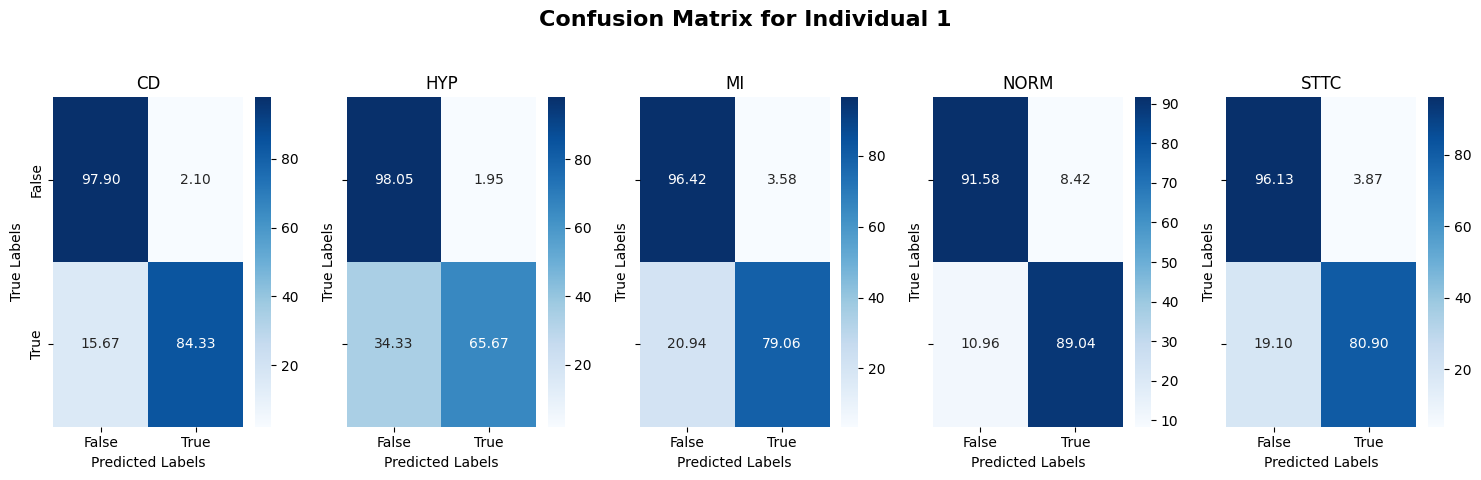

2024-04-17 00:23:20,455 - INFO - Calculating fitness for individual 2/15


X_params shape: (1, 2)
C: 100 gamma: 0.001


2024-04-17 00:26:00,273 - INFO - Fitness for individual 2: 0.8152895212173462


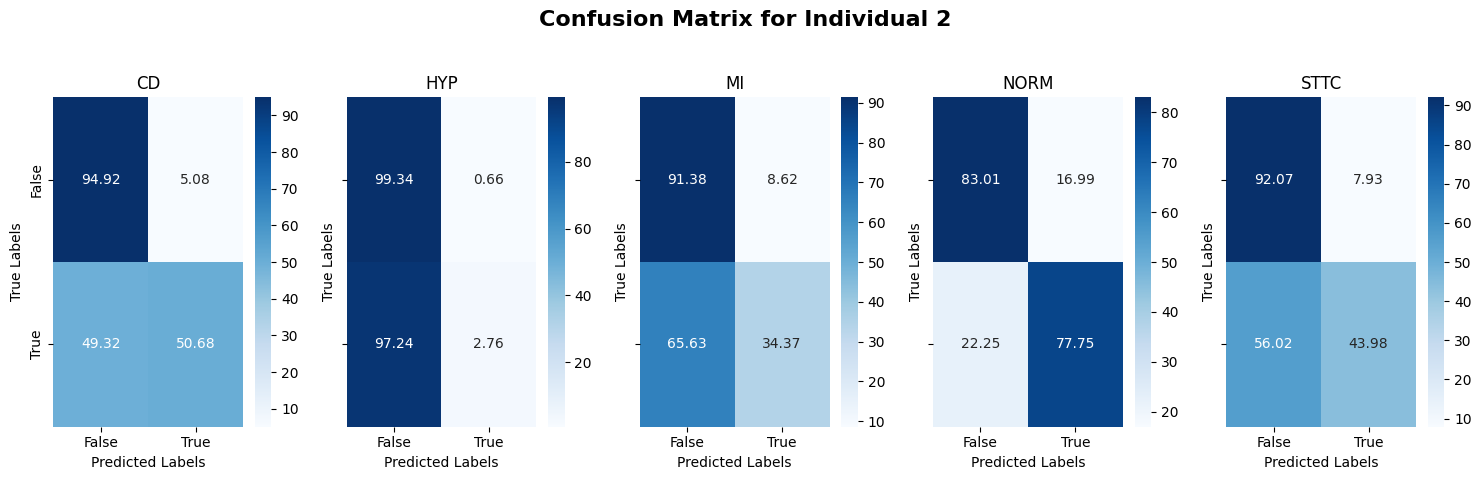

2024-04-17 00:26:02,302 - INFO - Calculating fitness for individual 3/15


X_params shape: (1, 2)
C: 100 gamma: 0.001


2024-04-17 00:28:42,878 - INFO - Fitness for individual 3: 0.8152895212173462


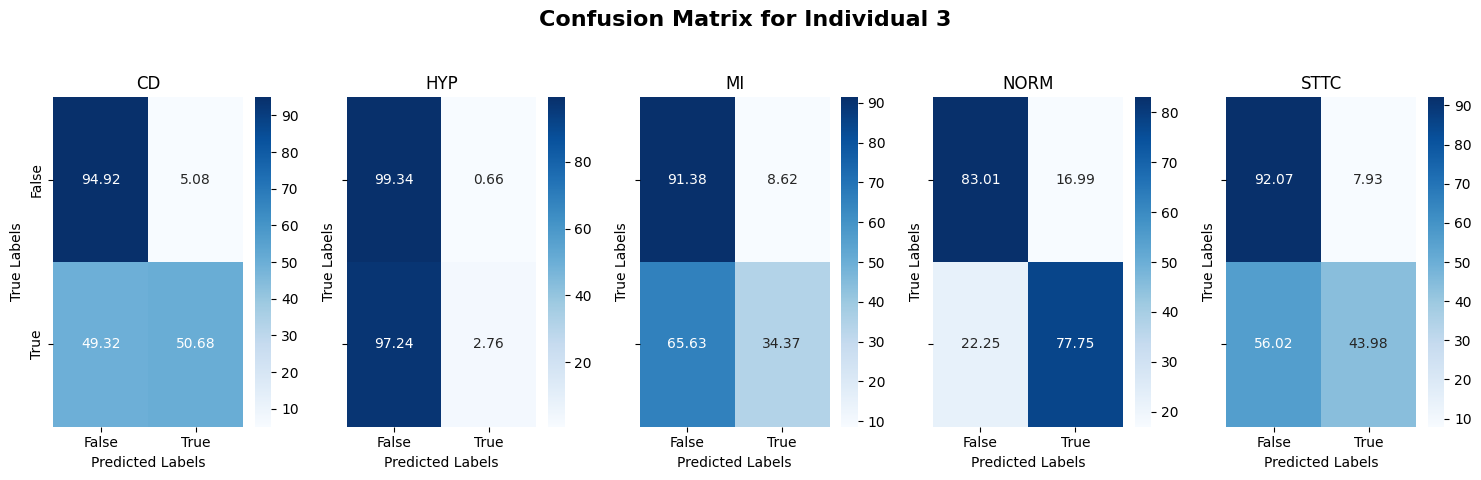

2024-04-17 00:28:44,919 - INFO - Calculating fitness for individual 4/15


X_params shape: (1, 2)
C: 100 gamma: 0.1


2024-04-17 00:56:04,328 - INFO - Fitness for individual 4: 0.8881612300872803


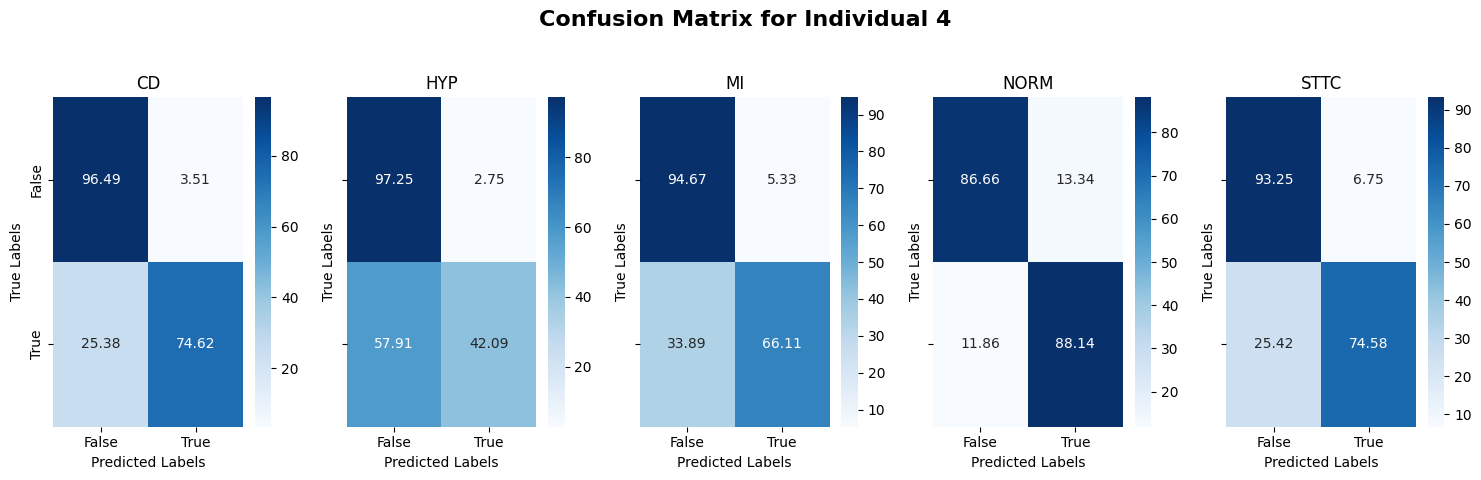

2024-04-17 00:56:06,521 - INFO - Calculating fitness for individual 5/15


X_params shape: (1, 2)
C: 0.001 gamma: 0.1


2024-04-17 00:57:23,285 - INFO - Fitness for individual 5: 0.7886031031608581


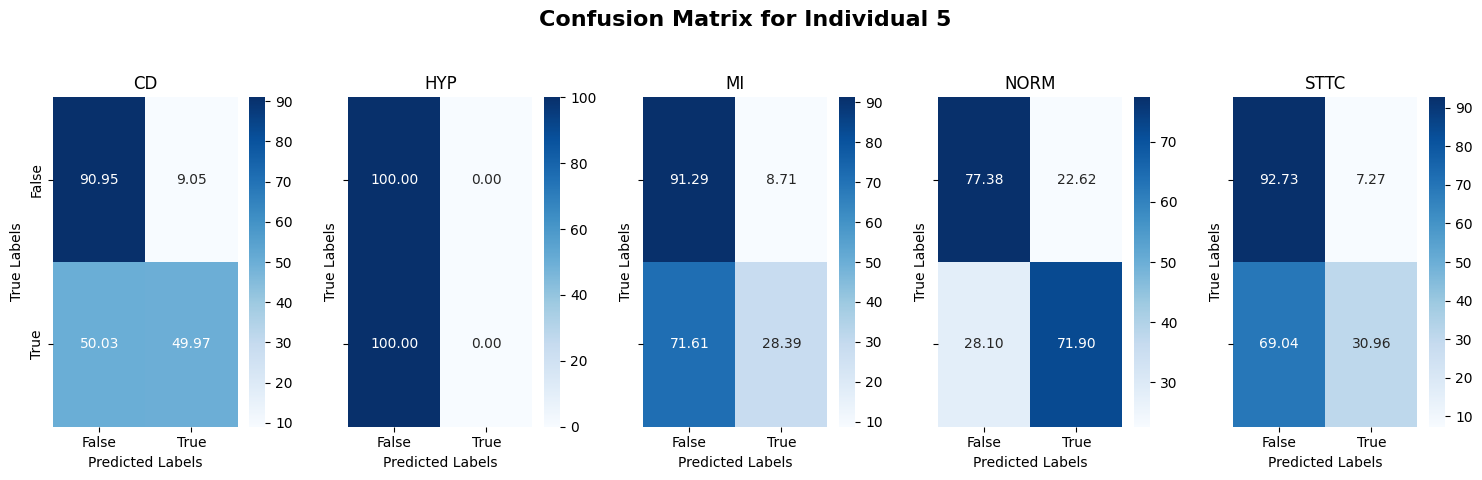

2024-04-17 00:57:25,275 - INFO - Calculating fitness for individual 6/15


X_params shape: (1, 2)
C: 100 gamma: 0.1


2024-04-17 01:24:18,674 - INFO - Fitness for individual 6: 0.8881612300872803


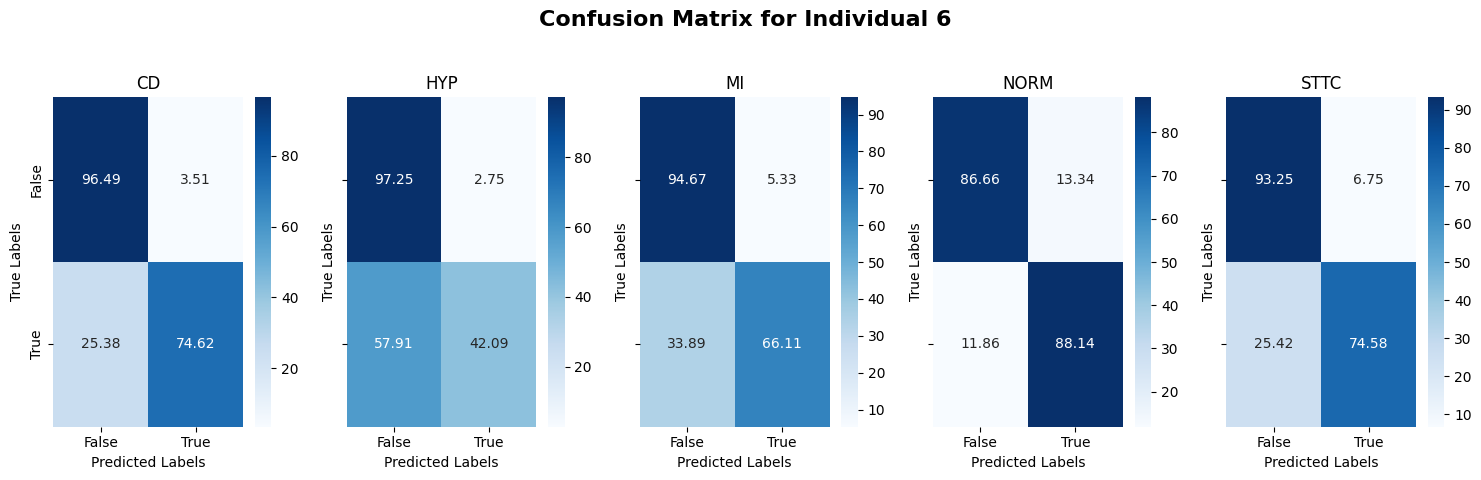

2024-04-17 01:24:20,603 - INFO - Calculating fitness for individual 7/15


X_params shape: (1, 2)
C: 100 gamma: 1


2024-04-17 01:31:07,541 - INFO - Fitness for individual 7: 0.9272304654121399


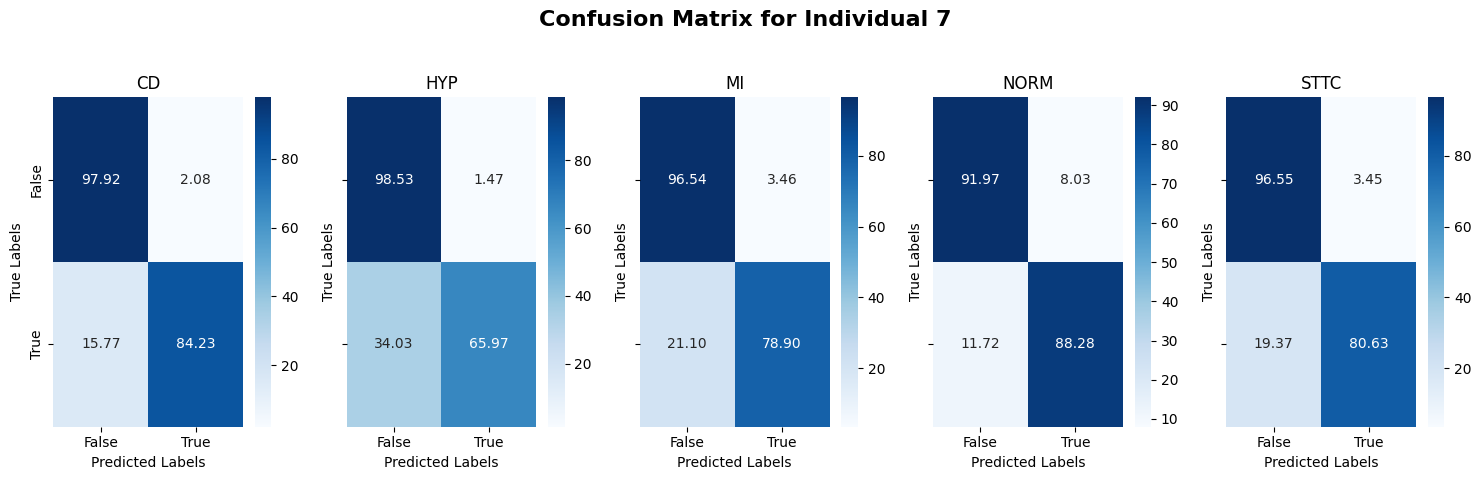

2024-04-17 01:31:09,444 - INFO - Calculating fitness for individual 8/15


X_params shape: (1, 2)
C: 1 gamma: 1


2024-04-17 01:33:23,741 - INFO - Fitness for individual 8: 0.901172399520874


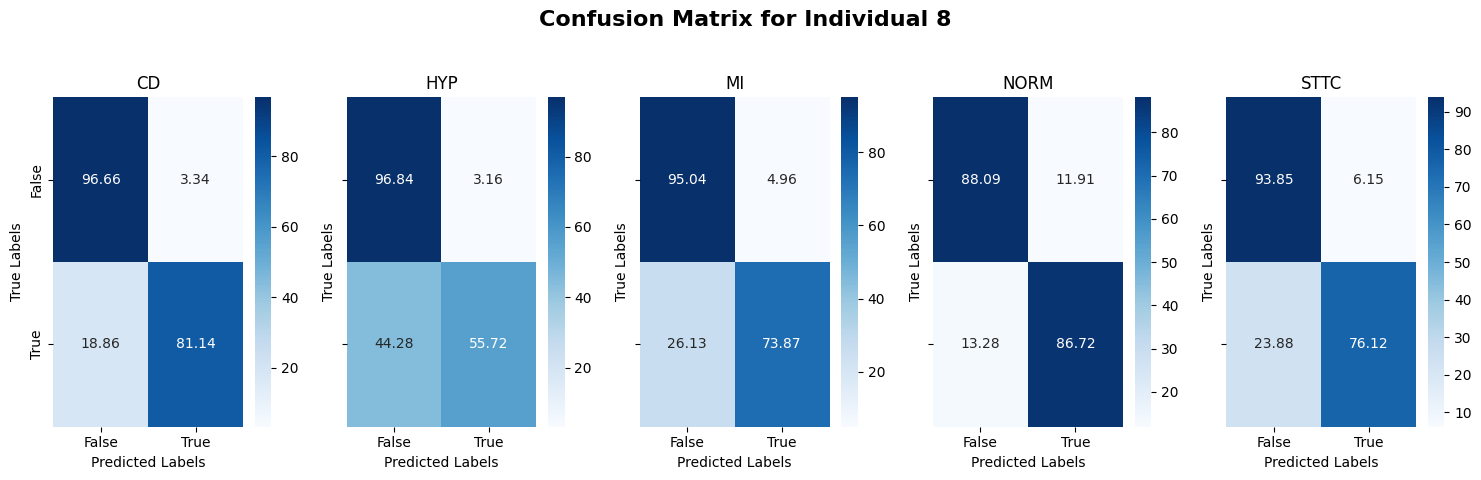

2024-04-17 01:33:25,952 - INFO - Calculating fitness for individual 9/15


X_params shape: (1, 2)
C: 100 gamma: 0.01


2024-04-17 01:36:39,711 - INFO - Fitness for individual 9: 0.8350642442703247


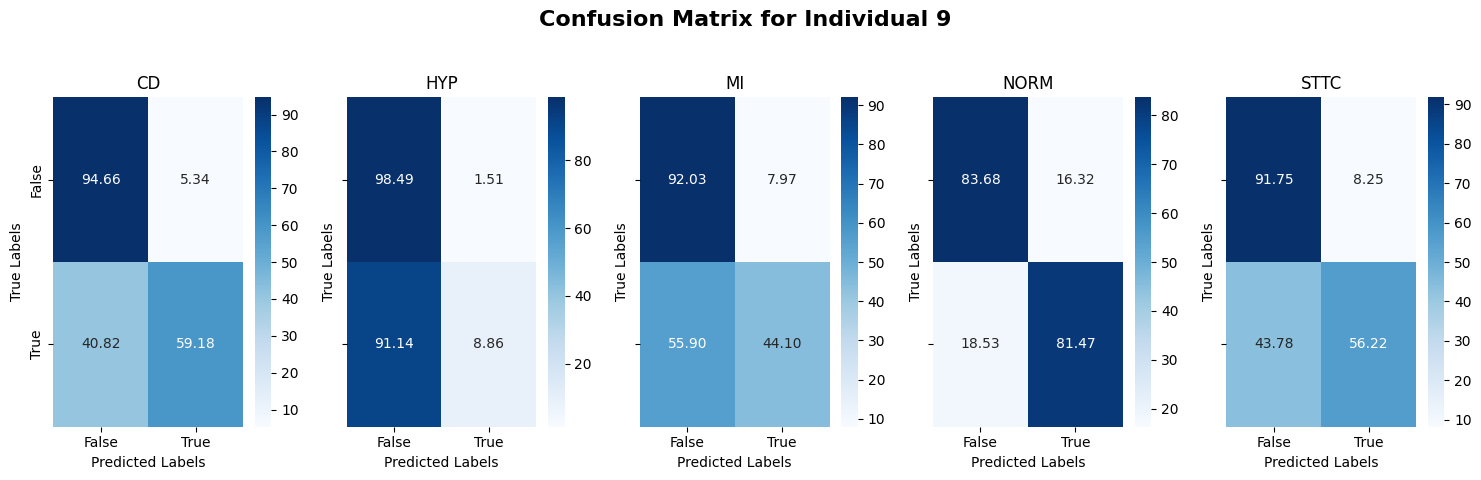

2024-04-17 01:36:41,755 - INFO - Calculating fitness for individual 10/15


X_params shape: (1, 2)
C: 10 gamma: 0.1


2024-04-17 01:40:21,953 - INFO - Fitness for individual 10: 0.8646369099617004


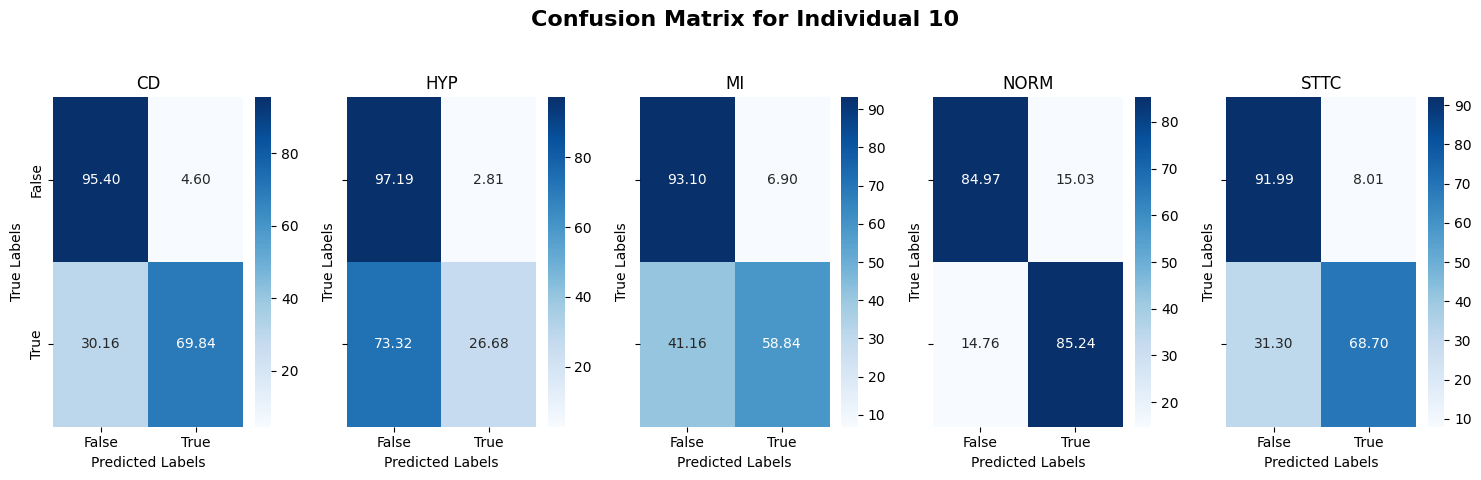

2024-04-17 01:40:23,879 - INFO - Calculating fitness for individual 11/15


X_params shape: (1, 2)
C: 1 gamma: 0.01


2024-04-17 01:41:33,660 - INFO - Fitness for individual 11: 0.8150340914726257


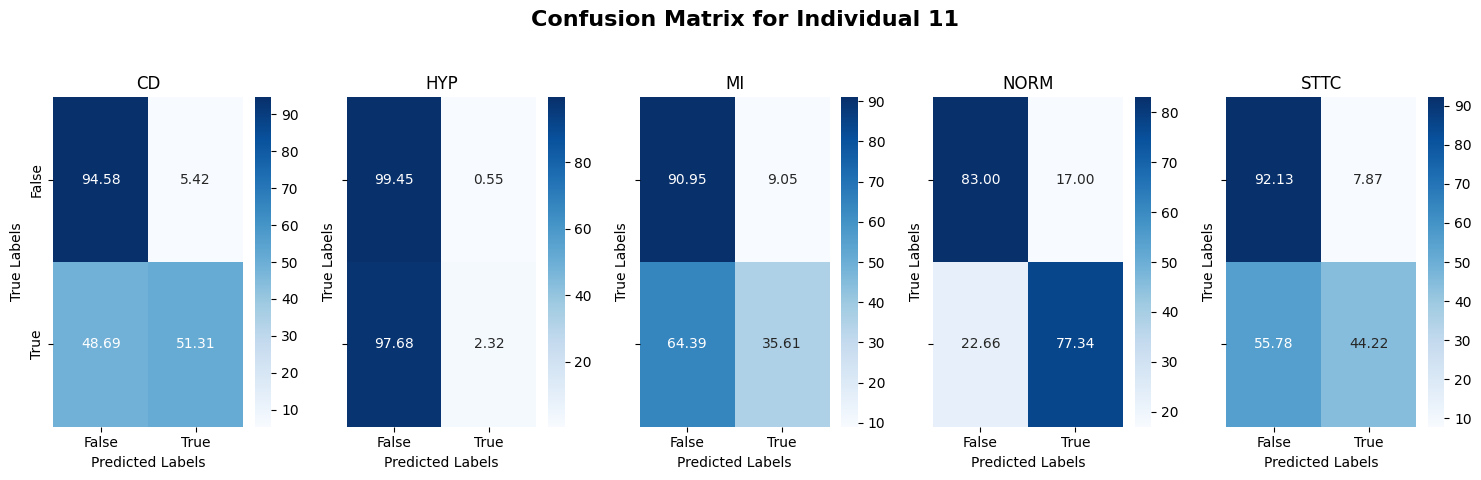

2024-04-17 01:41:35,712 - INFO - Calculating fitness for individual 12/15


X_params shape: (1, 2)
C: 10 gamma: 0.001


2024-04-17 01:42:48,748 - INFO - Fitness for individual 12: 0.8074889540672302


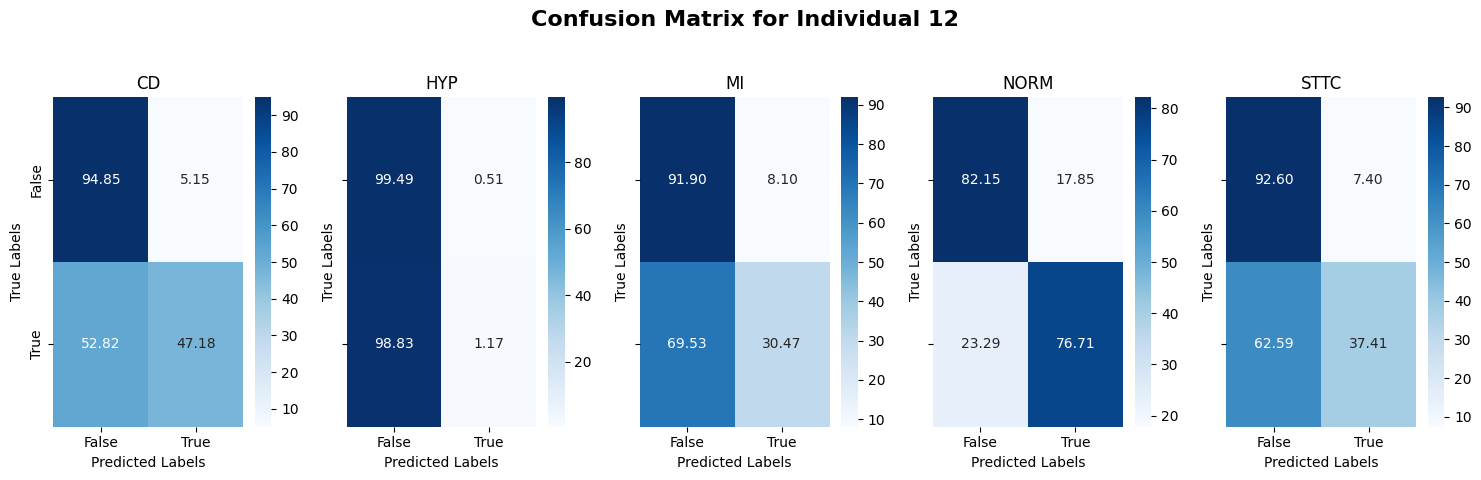

2024-04-17 01:42:50,741 - INFO - Calculating fitness for individual 13/15


X_params shape: (1, 2)
C: 0.01 gamma: 1


2024-04-17 01:44:19,941 - INFO - Fitness for individual 13: 0.7935838103294373


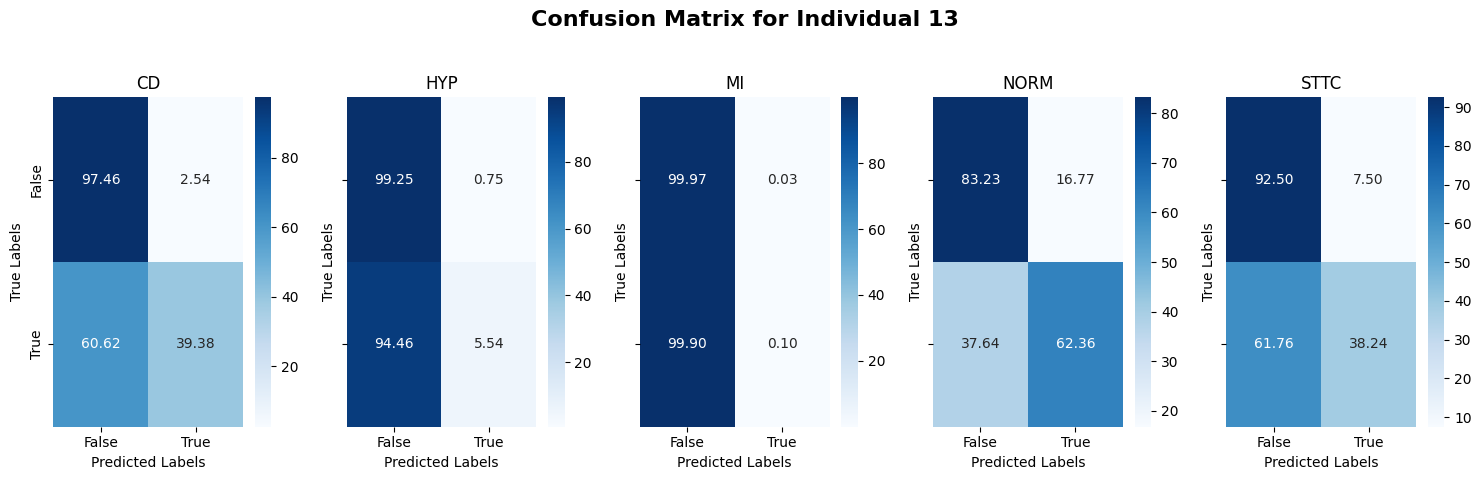

2024-04-17 01:44:21,785 - INFO - Calculating fitness for individual 14/15


X_params shape: (1, 2)
C: 0.1 gamma: 0.01


2024-04-17 01:45:31,608 - INFO - Fitness for individual 14: 0.804551613330841


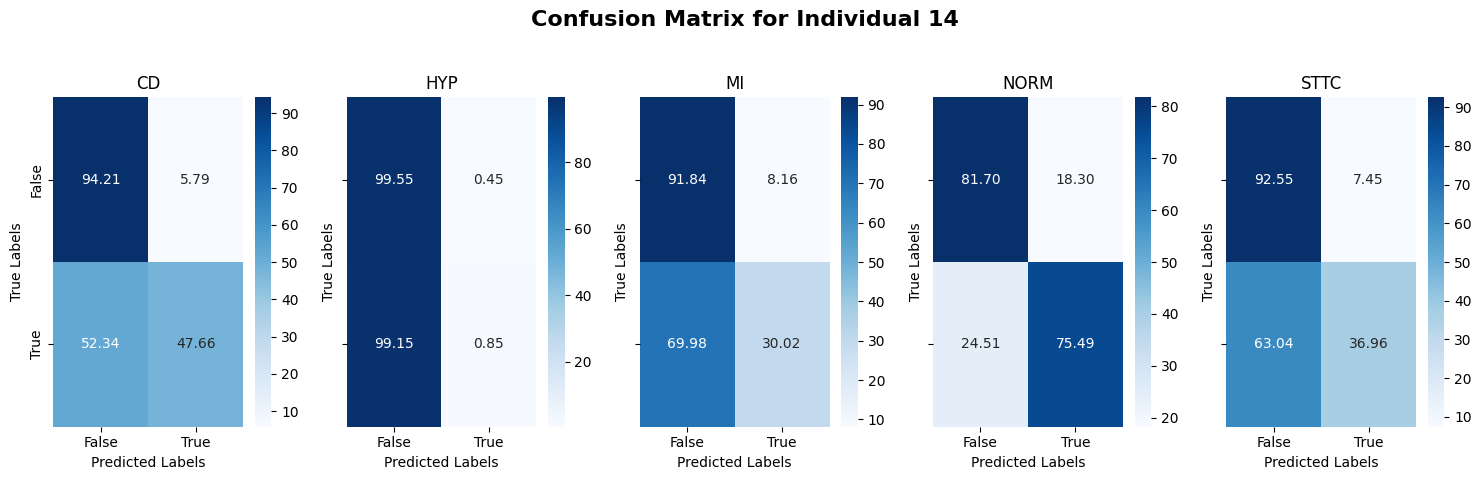

2024-04-17 01:45:33,597 - INFO - Calculating fitness for individual 15/15


X_params shape: (1, 2)
C: 0.1 gamma: 0.1


2024-04-17 01:46:39,741 - INFO - Fitness for individual 15: 0.8231054186820984


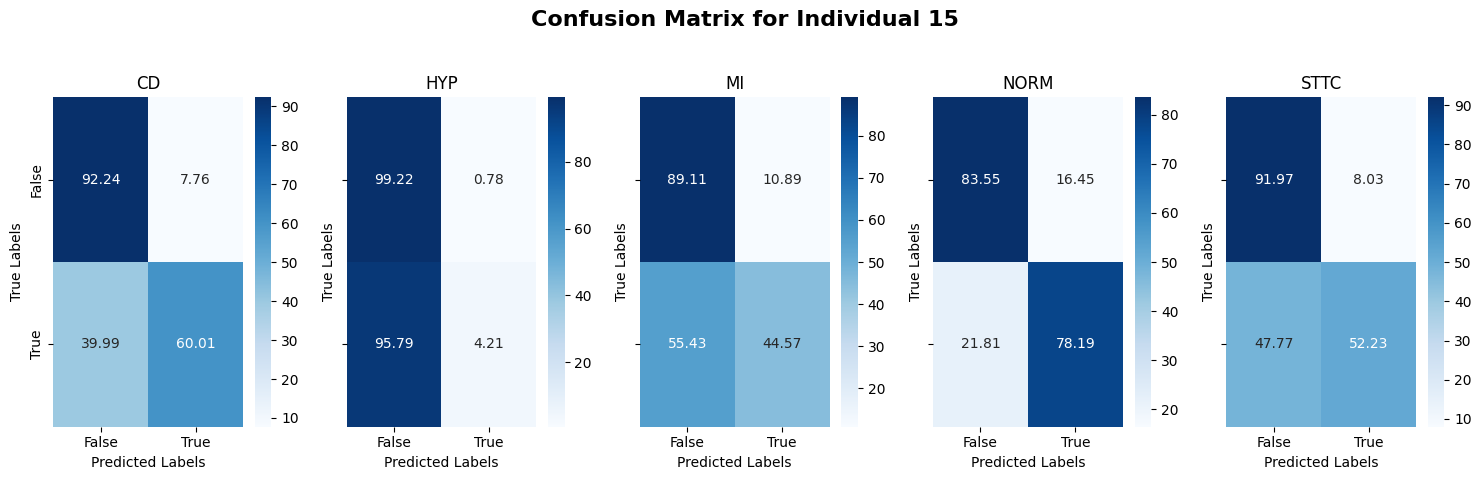

2024-04-17 01:46:41,967 - INFO - Calculating fitness for individual after 3 Phases 1/15


X_params shape: (1, 2)
C: 1 gamma: 1


2024-04-17 01:48:56,059 - INFO - Fitness for individual 1: 0.901172399520874


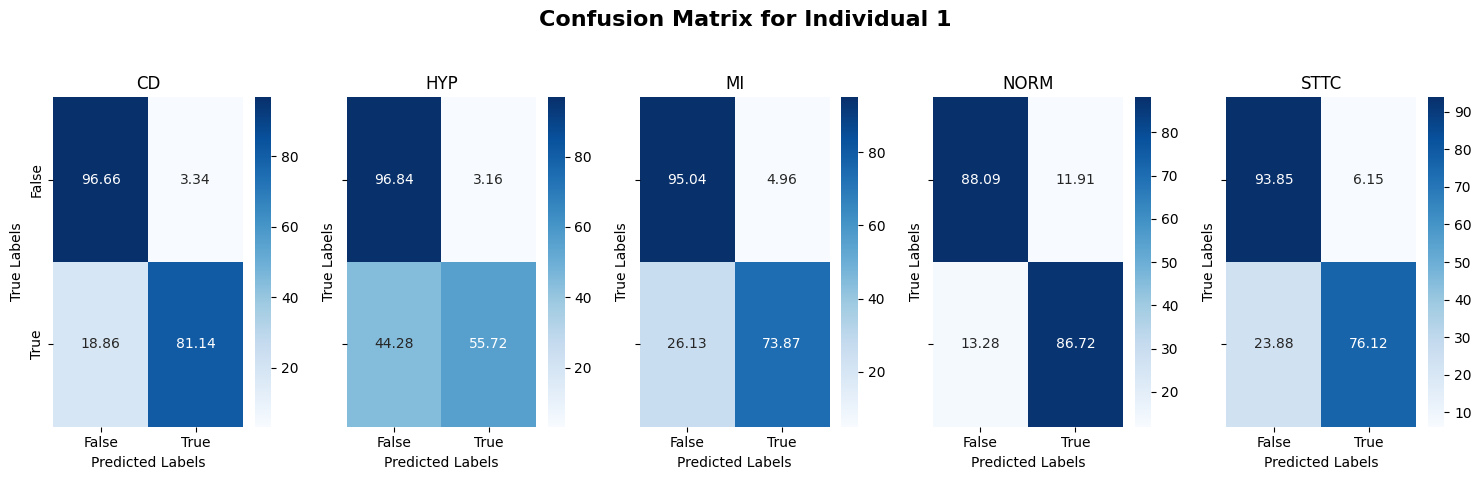

2024-04-17 01:48:57,927 - INFO - Calculating fitness for individual after 3 Phases 2/15


X_params shape: (1, 2)
C: 10 gamma: 0.001


2024-04-17 01:50:10,678 - INFO - Fitness for individual 2: 0.8074889540672302


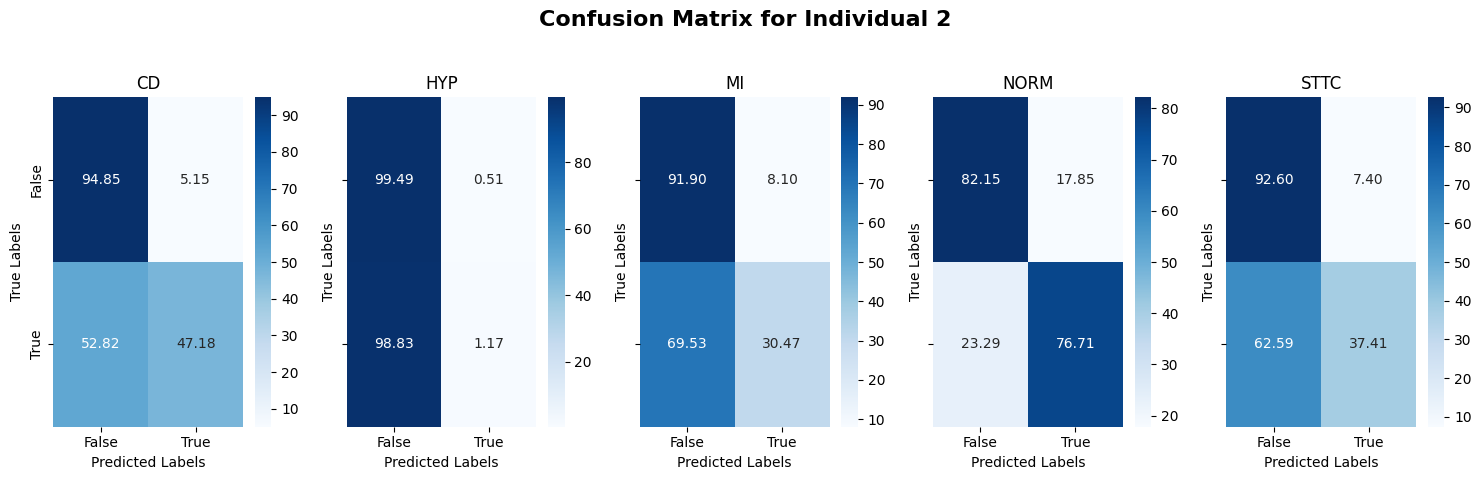

2024-04-17 01:50:12,680 - INFO - Calculating fitness for individual after 3 Phases 3/15


X_params shape: (1, 2)
C: 100 gamma: 0.01


2024-04-17 01:53:25,209 - INFO - Fitness for individual 3: 0.8350642442703247


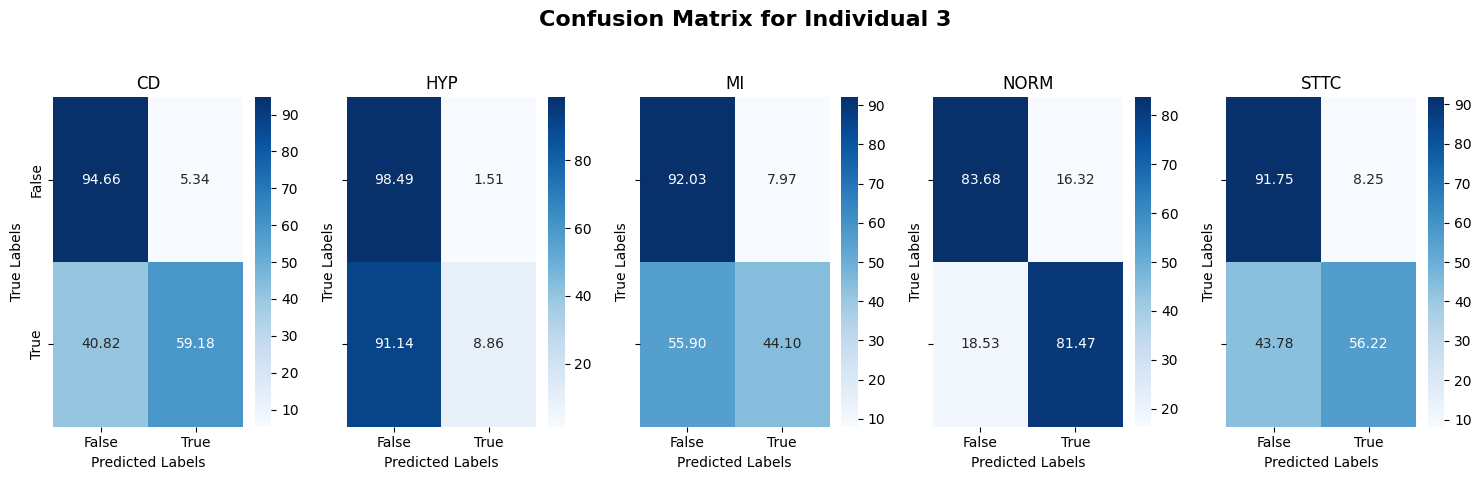

2024-04-17 01:53:27,198 - INFO - Calculating fitness for individual after 3 Phases 4/15


X_params shape: (1, 2)
C: 10 gamma: 1


2024-04-17 01:58:39,044 - INFO - Fitness for individual 4: 0.9259533524513245


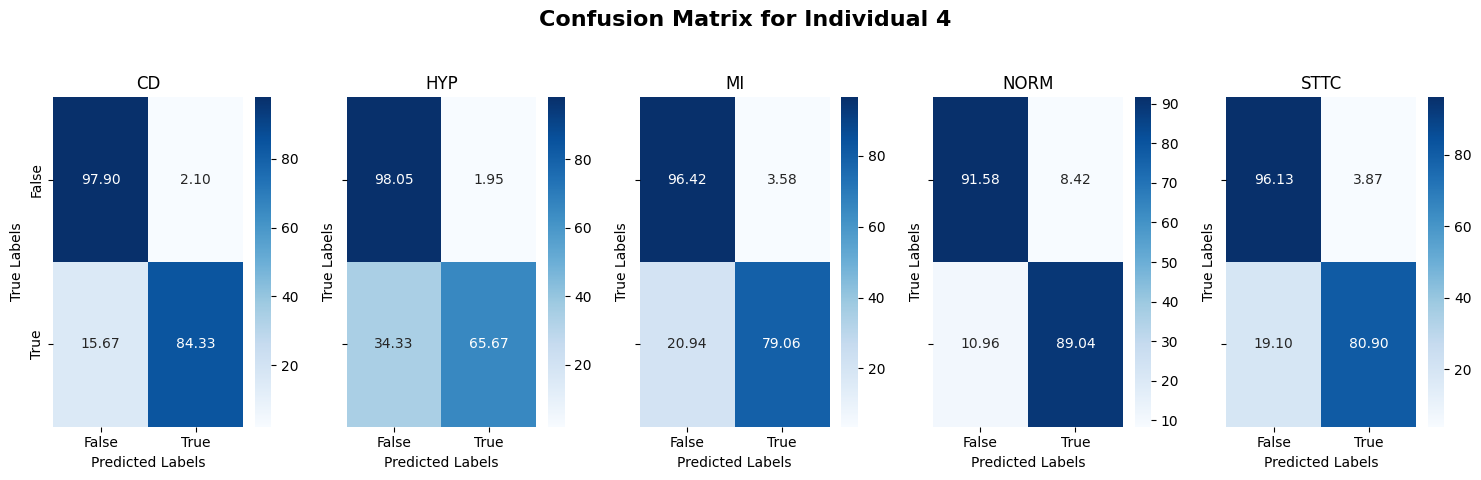

2024-04-17 01:58:41,146 - INFO - Calculating fitness for individual after 3 Phases 5/15


X_params shape: (1, 2)
C: 0.001 gamma: 1


2024-04-17 02:00:15,239 - INFO - Fitness for individual 5: 0.7701514720916748


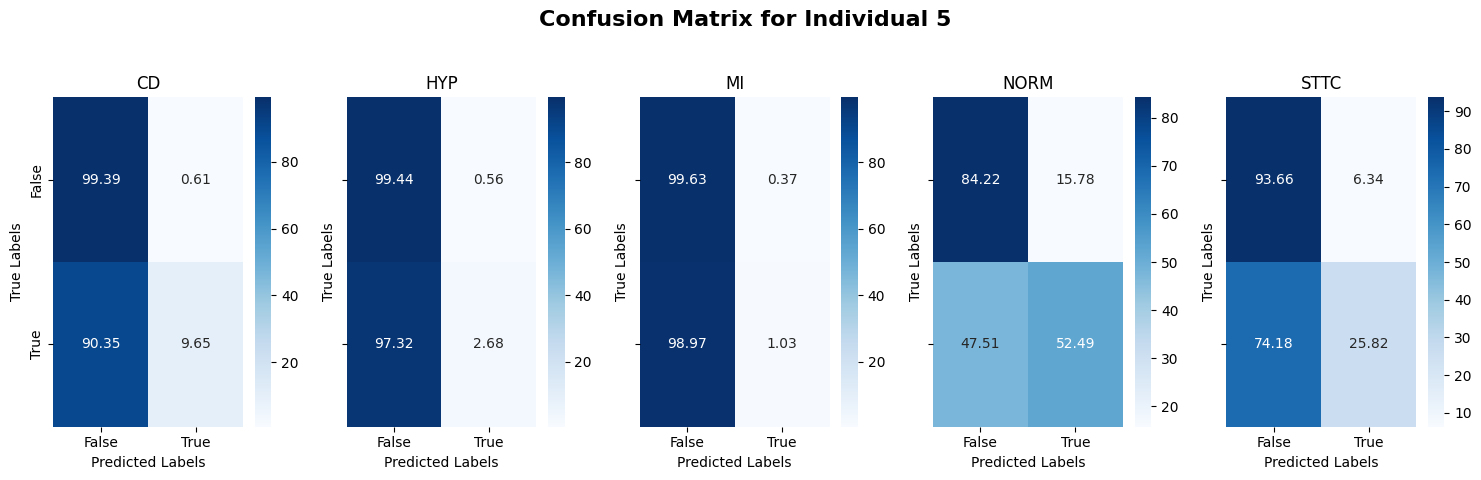

2024-04-17 02:00:17,097 - INFO - Calculating fitness for individual after 3 Phases 6/15


X_params shape: (1, 2)
C: 100 gamma: 0.1


2024-04-17 02:27:10,327 - INFO - Fitness for individual 6: 0.8881612300872803


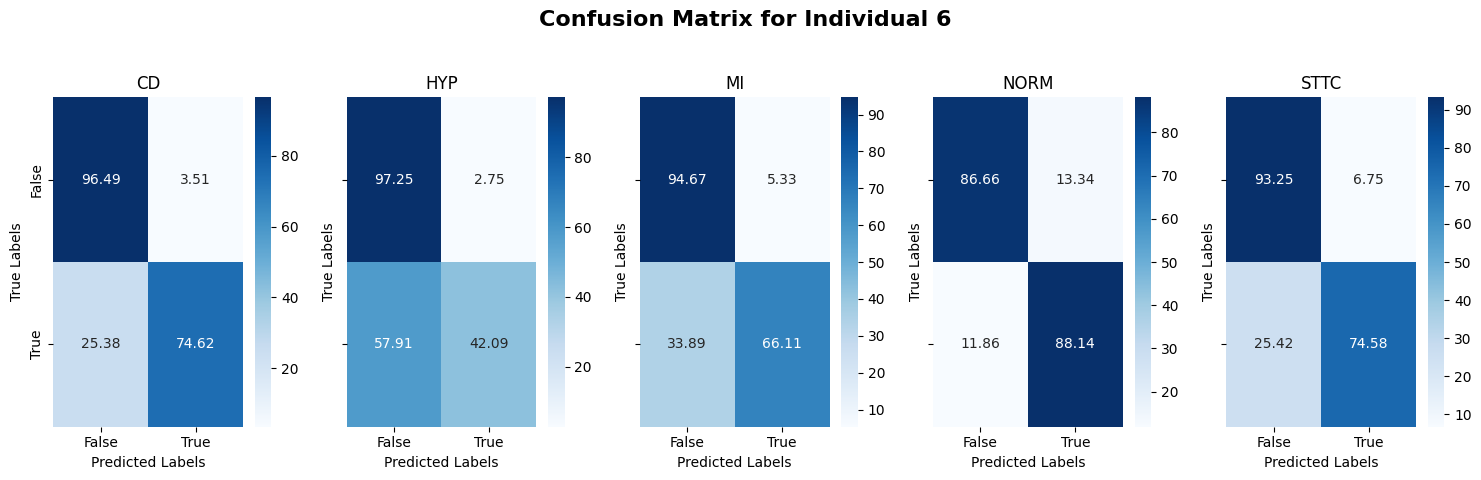

2024-04-17 02:27:12,245 - INFO - Calculating fitness for individual after 3 Phases 7/15


X_params shape: (1, 2)
C: 100 gamma: 1


2024-04-17 02:33:59,364 - INFO - Fitness for individual 7: 0.9272304654121399


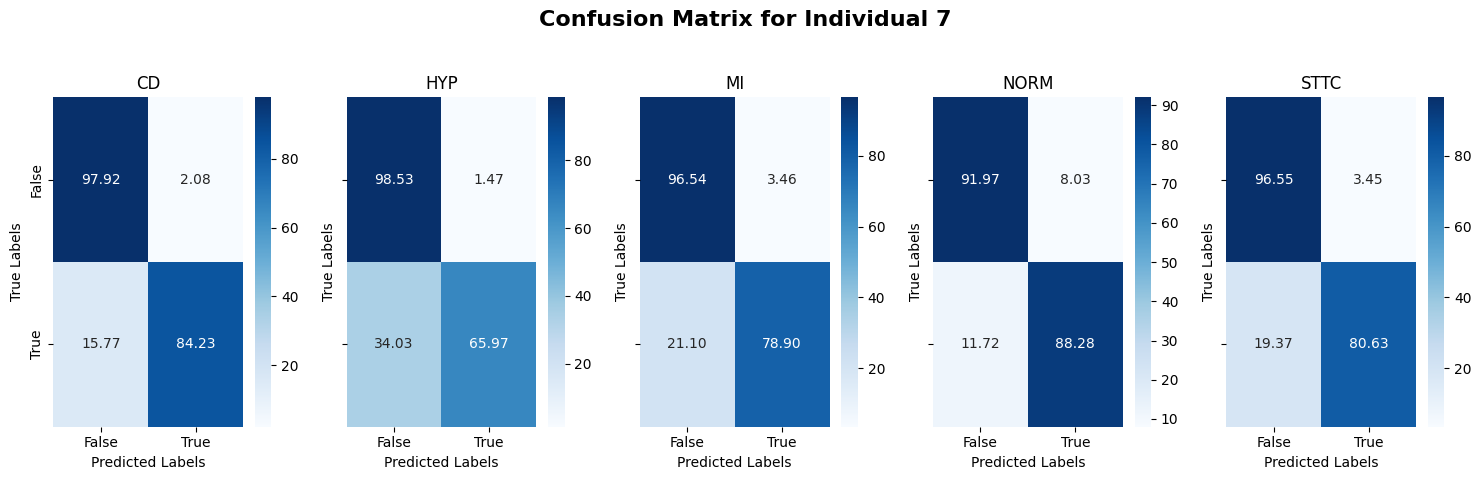

2024-04-17 02:34:01,290 - INFO - Calculating fitness for individual after 3 Phases 8/15


X_params shape: (1, 2)
C: 1 gamma: 1


2024-04-17 02:36:14,746 - INFO - Fitness for individual 8: 0.901172399520874


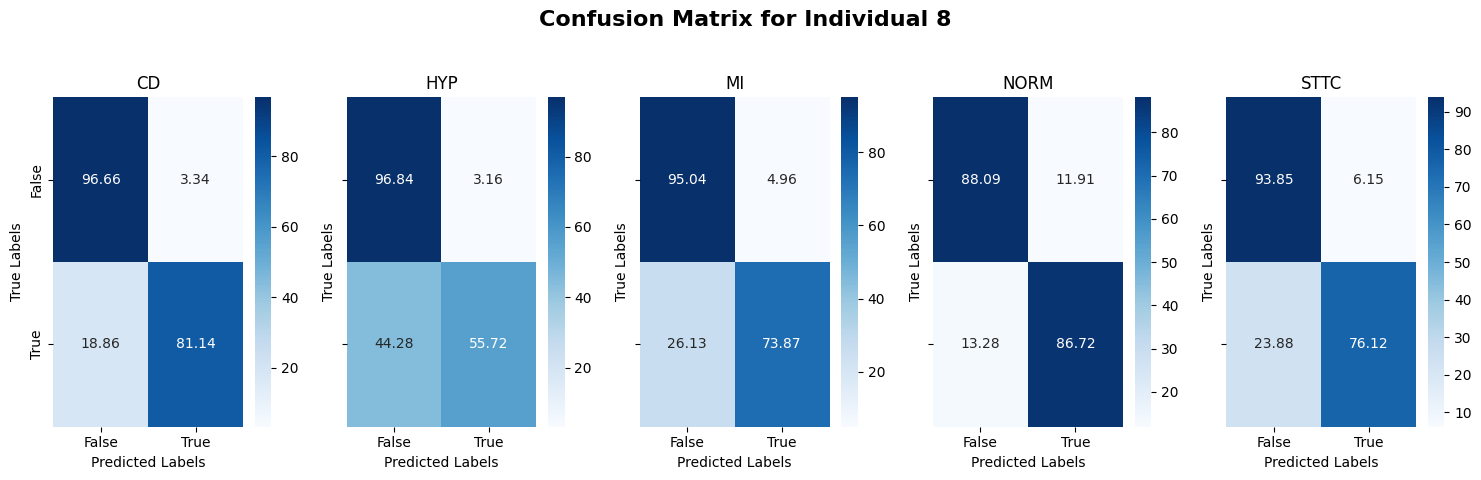

2024-04-17 02:36:16,898 - INFO - Calculating fitness for individual after 3 Phases 9/15


X_params shape: (1, 2)
C: 100 gamma: 0.01


2024-04-17 02:39:30,022 - INFO - Fitness for individual 9: 0.8350642442703247


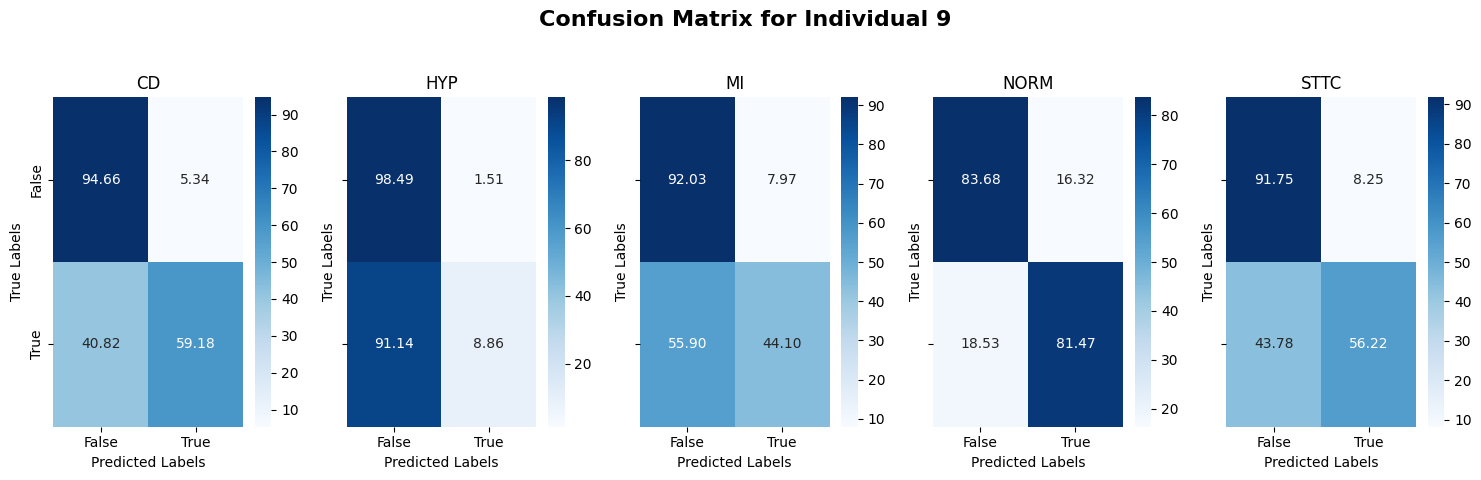

2024-04-17 02:39:32,136 - INFO - Calculating fitness for individual after 3 Phases 10/15


X_params shape: (1, 2)
C: 1 gamma: 0.1


2024-04-17 02:40:47,644 - INFO - Fitness for individual 10: 0.8413527131080627


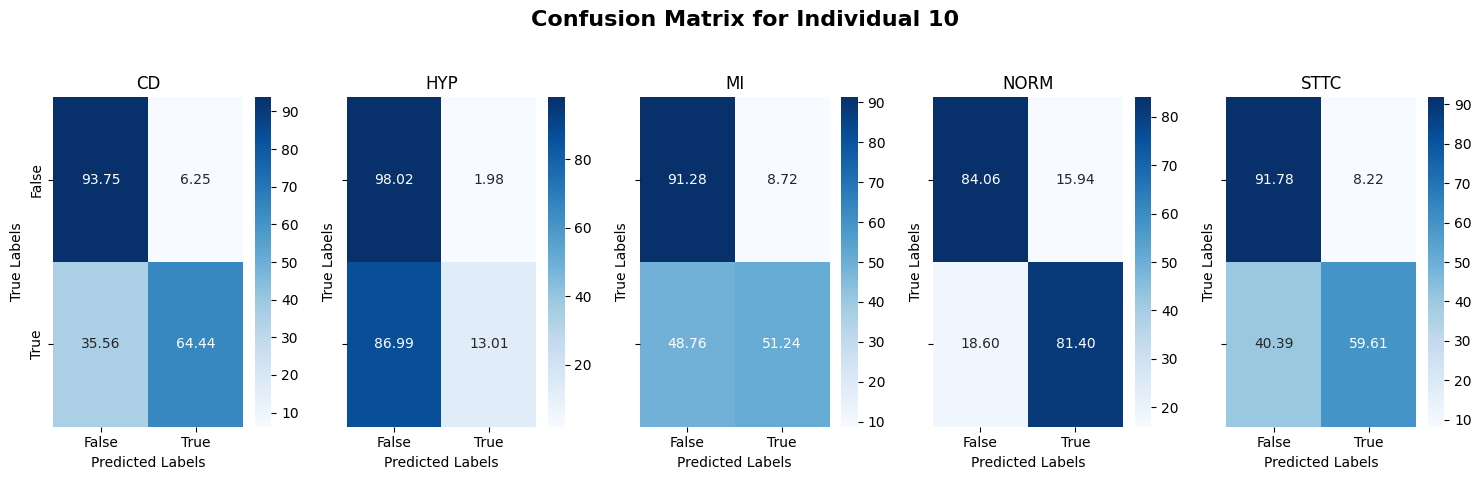

2024-04-17 02:40:49,652 - INFO - Calculating fitness for individual after 3 Phases 11/15


X_params shape: (1, 2)
C: 1 gamma: 1


2024-04-17 02:43:03,149 - INFO - Fitness for individual 11: 0.901172399520874


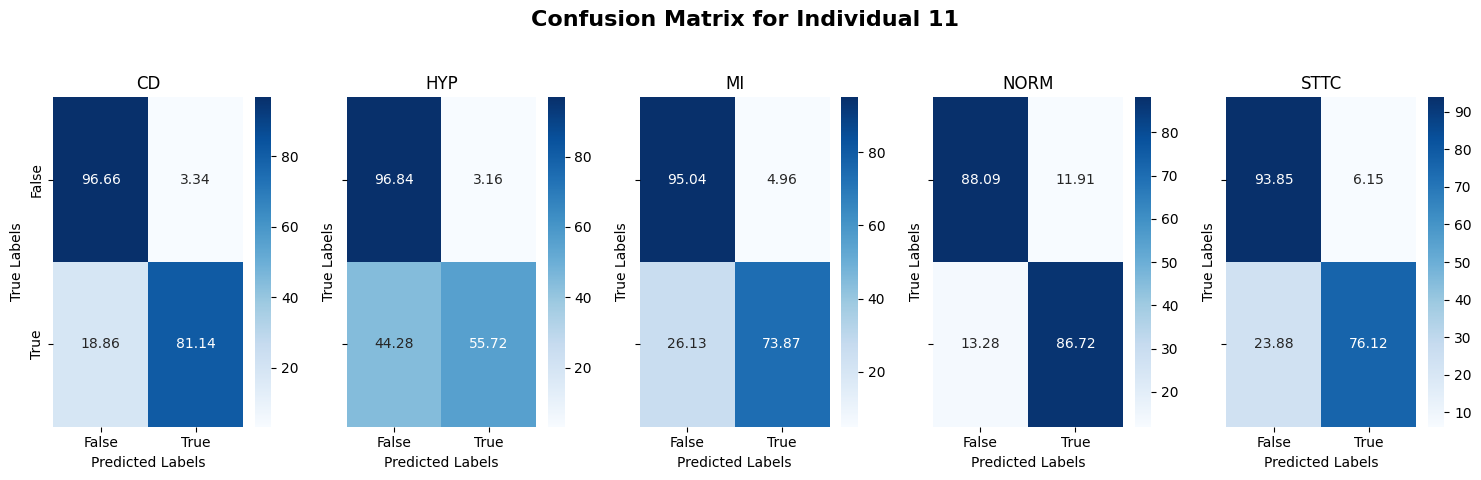

2024-04-17 02:43:05,014 - INFO - Calculating fitness for individual after 3 Phases 12/15


X_params shape: (1, 2)
C: 1 gamma: 0.001


2024-04-17 02:44:16,679 - INFO - Fitness for individual 12: 0.8010931849479676


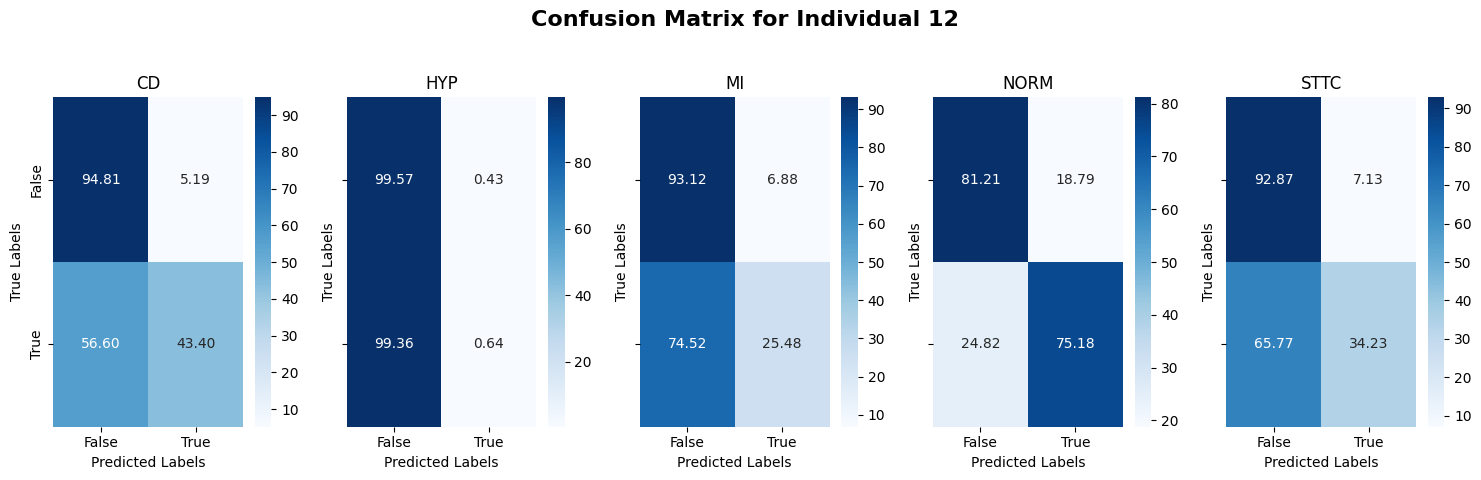

2024-04-17 02:44:18,936 - INFO - Calculating fitness for individual after 3 Phases 13/15


X_params shape: (1, 2)
C: 1 gamma: 1


2024-04-17 02:46:32,236 - INFO - Fitness for individual 13: 0.901172399520874


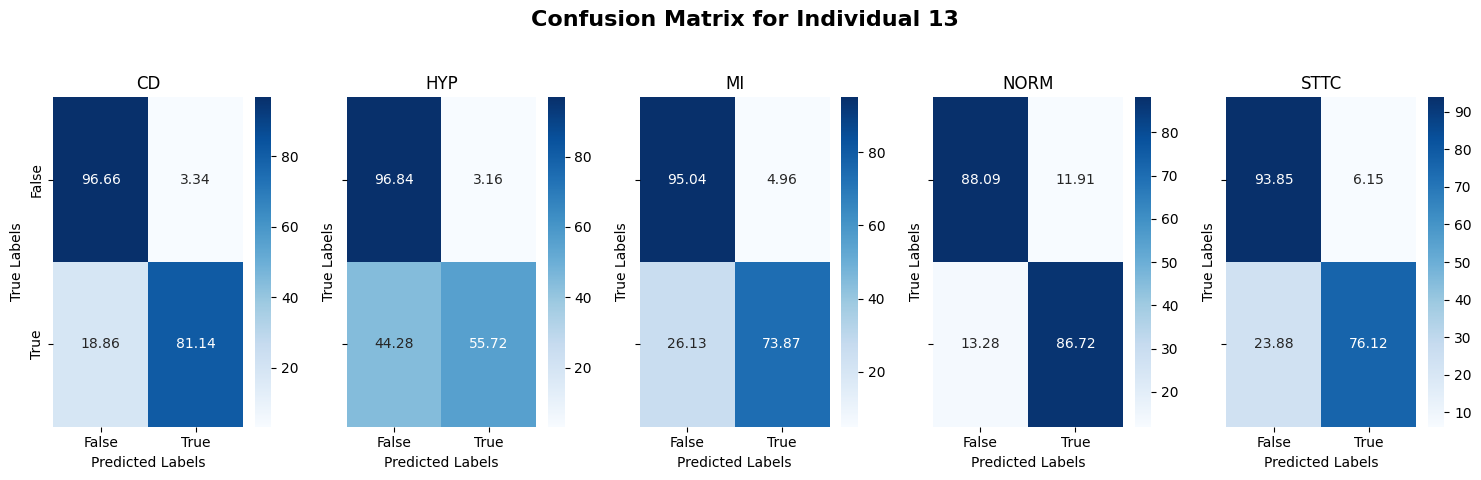

2024-04-17 02:46:34,088 - INFO - Calculating fitness for individual after 3 Phases 14/15


X_params shape: (1, 2)
C: 100 gamma: 0.01


2024-04-17 02:49:47,176 - INFO - Fitness for individual 14: 0.8350642442703247


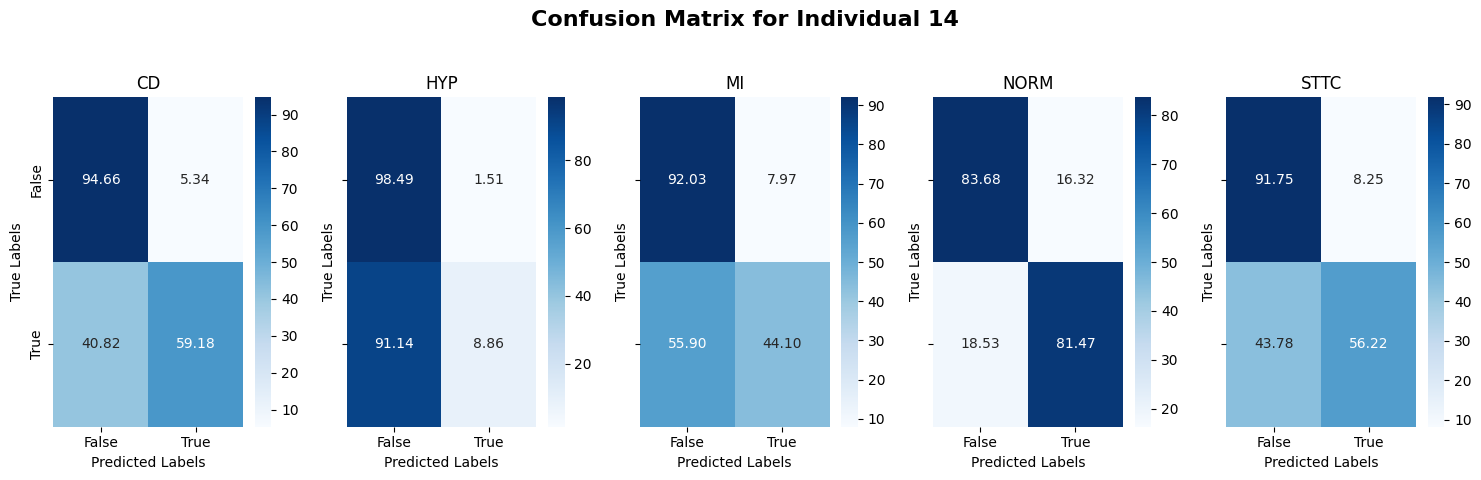

2024-04-17 02:49:49,162 - INFO - Calculating fitness for individual after 3 Phases 15/15


X_params shape: (1, 2)
C: 0.01 gamma: 0.1


2024-04-17 02:50:57,423 - INFO - Fitness for individual 15: 0.8077494859695434


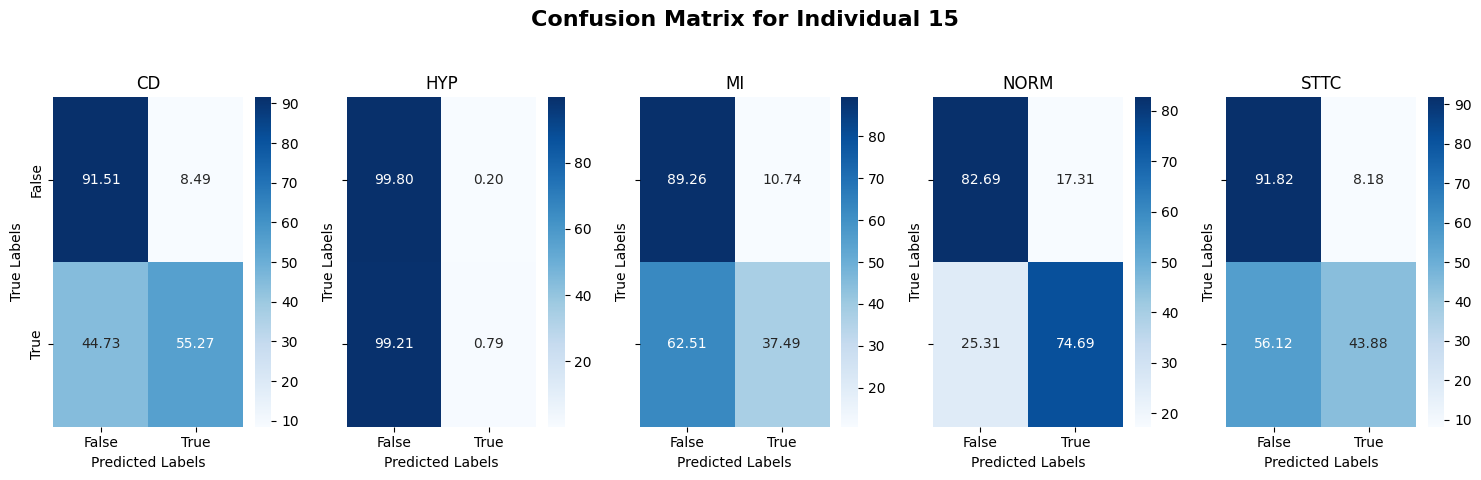

2024-04-17 02:50:59,404 - INFO - Iteration: 1/20, Best Fitness: 0.9272304654121399, Average Fitness: 0.8586042126019796
2024-04-17 02:50:59,406 - INFO - Fitness threshold reached: 0.9272304654121399 at iteration 1. Terminating...
2024-04-17 02:50:59,408 - INFO - Model saved to best_model_mpa_SVM_ptb_xl.pkl with fitness 0.9272304654121399 at iteration 1
2024-04-17 02:50:59,409 - INFO - Finished MPA_SVM optimization for PTB-XL dataset. Total duration: 153.10 minutes.
2024-04-17 02:50:59,410 - INFO - Top predator  position (exponential): [2, 0]
2024-04-17 02:50:59,411 - INFO - Top predator fitness: 0.9272304654121399


Top predator position (rounded to integers): [2, 0]
Top predator fitness: 0.9272304654121399


In [9]:
import time

def run_mpa_for_all_labels(X_train, X_val, y_train, y_val, search_agents_no, Max_iter, lb, ub, dim, svm_accuracy_fitness, fitness_threshold=0.90):
    """
    Runs MPA optimization for all labels and plots the convergence curve for each label.

    Parameters:
    - X_train, X_val, y_train, y_val: Training and validation sets.
    - search_agents_no: Number of search agents.
    - Max_iter: Maximum number of iterations.
    - lb, ub: Lower and upper bounds for optimization parameters.
    - dim: Number of dimensions/hyperparameters.
    - rf_accuracy_fitness: Fitness function for the Random Forest model.
    - fitness_threshold: Threshold for stopping the optimization.
    """
    overall_start_time = time.time()

    # Example usage with correctly structured return values for MPA
    results = {}  # Assuming MPA should populate this dictionary
    
    # Example call to MPA for one label (extend as needed for multiple labels)
    top_predator_pos, top_predator_fit = MPA(
        search_agents_no, Max_iter, lb, ub, dim, 
        X_train, y_train, X_val, y_val, 
        svm_accuracy_fitness, fitness_threshold
    )
    
    # Rounding top predator position to nearest integers for logging and usage
    rounded_top_predator_pos = [round(pos) for pos in top_predator_pos]

    # Populate the results dictionary with mock label data (extend as needed)
    results['MockLabel'] = {
        'Top_predator_pos': rounded_top_predator_pos,
        'Top_predator_fitness': top_predator_fit
    }

    overall_end_time = time.time()
    total_duration_minutes = (overall_end_time - overall_start_time) / 60

    # Get the top predator position and fitness from the 'results' dictionary for the mock label
    top_predator_pos = results['MockLabel']['Top_predator_pos']
    top_predator_fit = results['MockLabel']['Top_predator_fitness']
    
    # Log the top predator fitness and position
    logging.info(f"Finished MPA_SVM optimization for PTB-XL dataset. Total duration: {total_duration_minutes:.2f} minutes.")
    logging.info(f"Top predator  position (exponential): {top_predator_pos}")
    logging.info(f"Top predator fitness: {top_predator_fit}")
    
    # Optionally, print them out to the console as well
    print(f"Top predator position (rounded to integers): {top_predator_pos}")
    print(f"Top predator fitness: {top_predator_fit}")


run_mpa_for_all_labels(X_train, X_val, y_train, y_val, search_agents_no, Max_iter, lb, ub, dim, svm_accuracy_fitness, fitness_threshold=0.90)


### Evaluate on Test dataset

In [11]:
import cudf
# Example loading test data (adjust path and processing as needed)
test_data = cudf.read_csv('/home/jupyter-yangiev/MPA_int_ML/Test_new.csv')

features = [str(i) for i in range(187)] + [f'coeff{i}' for i in range(1, 221)] + ['SDNN', 'RMSSD', 'Mean_P_Wave_Duration', 'Mean_QRS_Duration', 'Mean_T_Wave_Duration', 'Mean_QT_Interval', 'Mean_PR_Interval']
labels = ['CD', 'HYP', 'MI', 'NORM', 'STTC']

X_test = test_data[features].astype('float32')
y_test = test_data[labels].astype('int32')  # Adjust label column as per your dataset

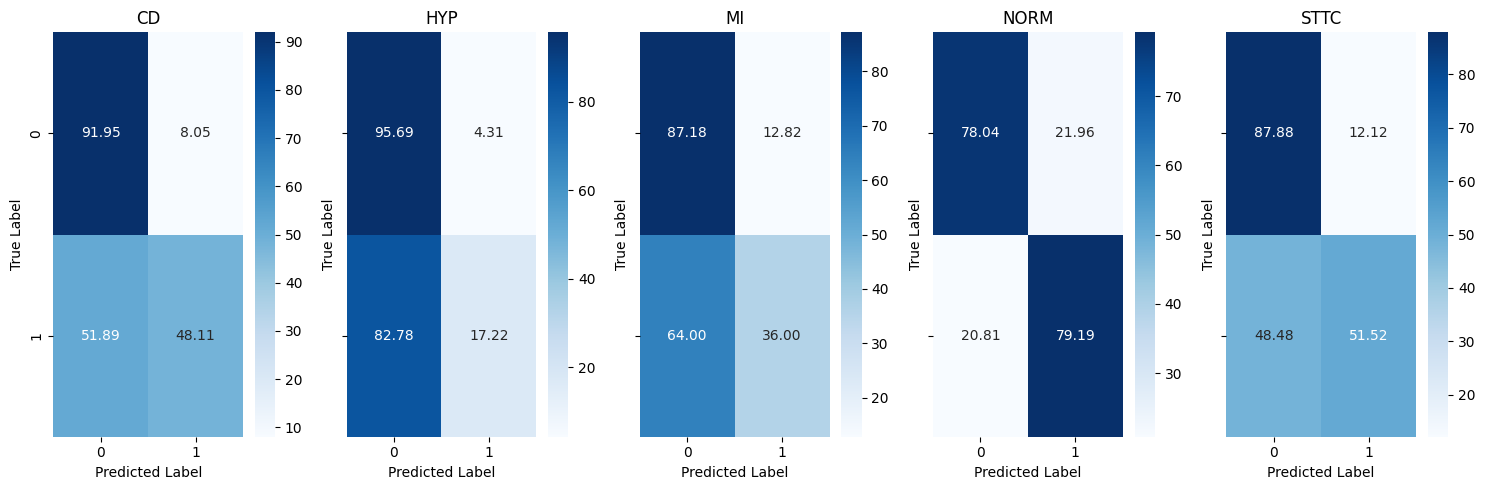

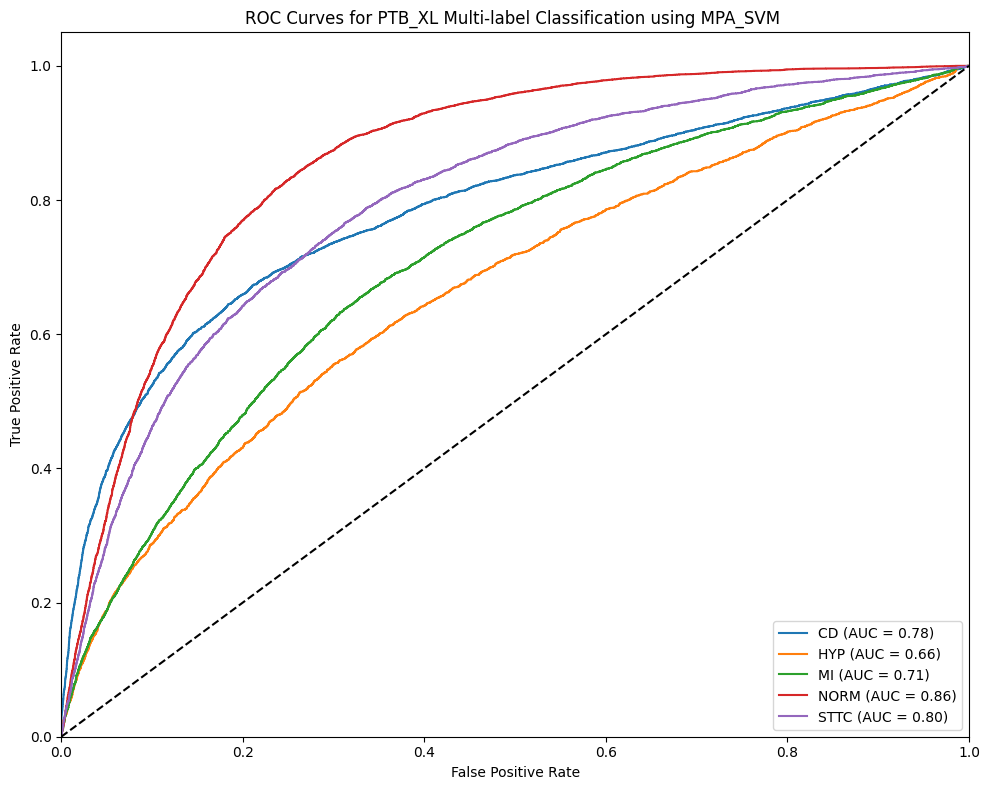

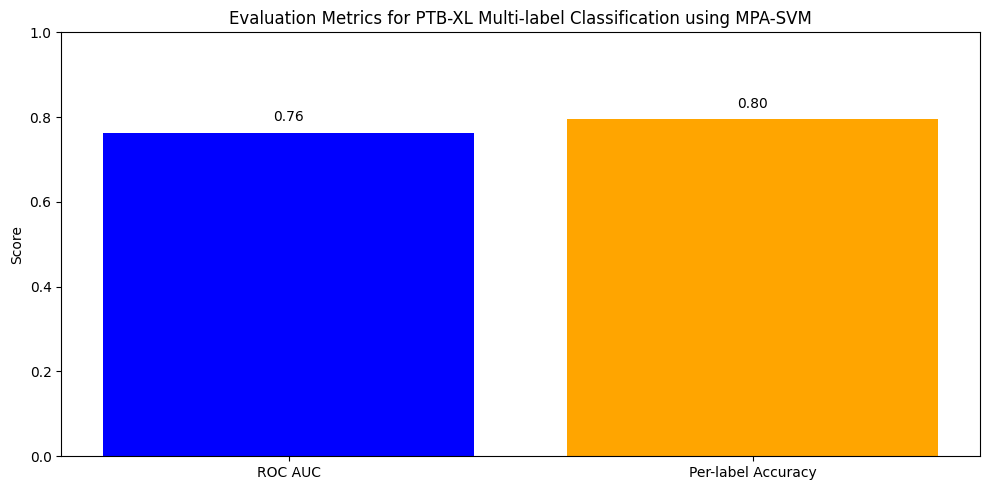

Classification Report for CD:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     16785
           1       0.65      0.48      0.55      5280

    accuracy                           0.81     22065
   macro avg       0.75      0.70      0.72     22065
weighted avg       0.80      0.81      0.80     22065

Classification Report for HYP:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     19283
           1       0.37      0.17      0.23      2782

    accuracy                           0.86     22065
   macro avg       0.63      0.56      0.58     22065
weighted avg       0.82      0.86      0.84     22065

Classification Report for MI:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83     16079
           1       0.51      0.36      0.42      5986

    accuracy                           0.73     22065
   macro avg       0.65      0.62    

In [29]:
import cudf
import cupy as cp
from cuml.svm import SVC as cumlSVC
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize the SVM model
model = cumlSVC(C=100, gamma=0.1, probability=True, class_weight='balanced', cache_size=500)

# Prepare to store predictions and probabilities
y_probs = {}
y_preds = {}
roc_aucs = []
accuracies = []

# Plot confusion matrices
num_labels = len(labels)
# Plot confusion matrices
fig_cm, axes_cm = plt.subplots(1, num_labels, figsize=(15, 5), sharey=True)  # Create a new figure for confusion matrices


for idx, label in enumerate(labels):
    model.fit(X_train, y_train[label])
    # Predict probabilities and labels
    y_prob_gpu = model.predict_proba(X_test)
    y_probs[label] = y_prob_gpu.get() if isinstance(y_prob_gpu, cp.ndarray) else y_prob_gpu.values.get()
    y_pred_gpu = model.predict(X_test)
    y_preds[label] = y_pred_gpu.get() if isinstance(y_pred_gpu, cp.ndarray) else y_pred_gpu.to_numpy()
     
    # Convert to NumPy arrays for calculation
    y_true_np = y_test[label].to_numpy()
    y_score_np = cp.asnumpy(y_probs[label])

    # Calculate accuracy
    accuracy = np.mean(y_preds[label] == y_true_np)
    accuracies.append(accuracy)
    
    # Calculate and plot confusion matrix
    cm = confusion_matrix(y_true_np, y_preds[label])
    cm_percentage = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', ax=axes_cm[idx])
    axes_cm[idx].set_title(f'{label}')
    axes_cm[idx].set_xlabel('Predicted Label')
    axes_cm[idx].set_ylabel('True Label')

plt.tight_layout()
plt.savefig('confusion_matrices_mpa_SVM_ptb_xl.png', dpi=300)  # Save confusion matrices as high-res PNG
plt.show()

# Now plot ROC curves
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))  # Create a new figure for ROC curves

for idx, label in enumerate(labels):
    # Ensure y_probs[label] is accessing the correct class probabilities; typically the positive class
    # Check how y_probs is structured; assuming it stores probabilities for all classes
    # We select the probabilities for the positive class (index 1 if binary: [0, 1])
    positive_class_probabilities = y_probs[label][:, 1] if y_probs[label].ndim > 1 else y_probs[label]

    # Ensure y_test[label] is a 1D array
    y_test_label = y_test[label].to_numpy() if not isinstance(y_test[label], np.ndarray) else y_test[label]

    fpr, tpr, _ = roc_curve(y_test_label, positive_class_probabilities)
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)
    ax_roc.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

ax_roc.plot([0, 1], [0, 1], 'k--')
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curves for PTB_XL Multi-label Classification using MPA_SVM ')
ax_roc.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve_mpa_SVM_ptb_xl.png', format='png', dpi=300)  # Save ROC curves as high-res PNG
plt.show()

# Plot ROC-AUC and Accuracy in a bar chart
plt.figure(figsize=(10, 5))
metrics = ['ROC AUC', 'Per-label Accuracy']
scores = [np.mean(roc_aucs), np.mean(accuracies)]
plt.bar(metrics, scores, color=['blue', 'orange'])
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')
plt.title('Evaluation Metrics for PTB-XL Multi-label Classification using MPA-SVM')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.tight_layout()
plt.savefig('evaluation_metrics_mpa_SVM_ptb_xl.png', dpi=300)
plt.show()

# Print classification report for each label
for label in labels:
    print(f'Classification Report for {label}:')
    print(classification_report(y_test[label].to_numpy(), y_preds[label]))

